In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import zipfile
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import nipy
from sklearn.model_selection import train_test_split
import cv2
from project import Utils
from enum import Enum
import nibabel as nib

In [2]:
TRAIN_DIR = "../database/training"
TEST_DIR = "../database/testing"

In [3]:
class Frame(Enum):
    FULL = 0
    END_DIASTOLIC = 1
    END_SYSTOLIC = 2

volume per voxel:  18.6920166015625
Patient: 26
Image Shape: (216, 256, 10)
Mask Shape: (216, 256, 10)


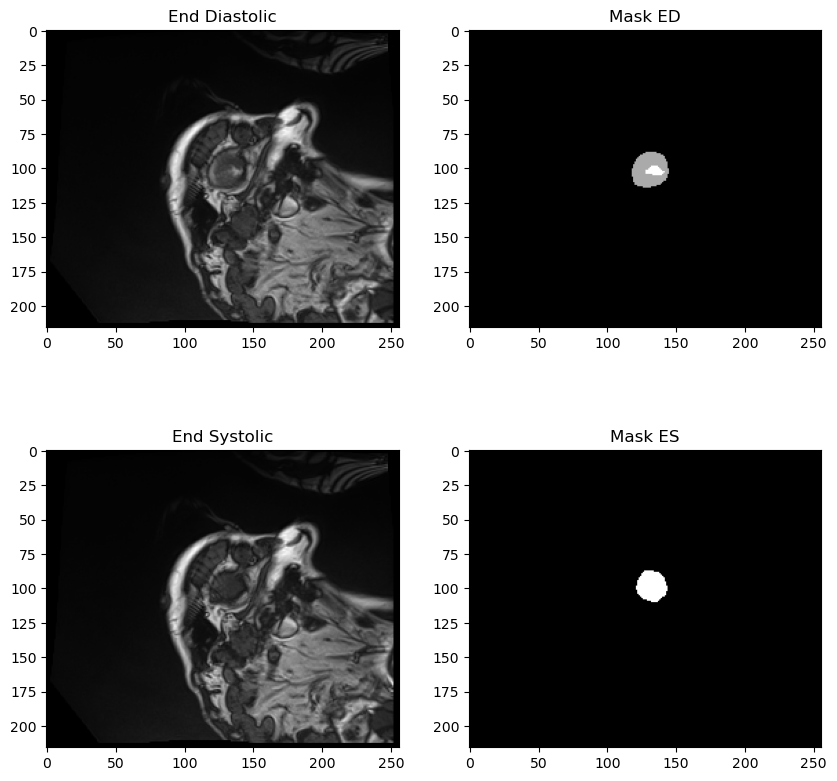

In [4]:
util = Utils(TRAIN_DIR)

In [5]:
df = util.train_val
df

,PtNum,ED,ES,Group,Height,NbFrame,Weight,XLen,YLen,ZLen,Time
0,1,1,12,DCM,184.0,30,95.0,216,256,10,30
1,2,1,12,DCM,160.0,30,70.0,232,256,10,30
2,3,1,15,DCM,165.0,30,77.0,256,256,10,30
3,4,1,15,DCM,159.0,28,46.0,232,256,10,28
4,5,1,13,DCM,165.0,30,77.0,256,216,10,30
...,...,...,...,...,...,...,...,...,...,...,...
95,96,1,8,RV,186,15,76,174,208,18,15
96,97,1,11,RV,187,30,82,216,256,8,30
97,98,1,9,RV,167,22,50,216,256,7,22
98,99,1,9,RV,180,19,80,154,224,16,19


In [6]:
MaxX, MaxY, MaxZ = 512, max(df.YLen), max(df.ZLen)
MaxX, MaxY, MaxZ

(512, 512, 18)

In [7]:
labels = df.Group

In [8]:
labels = np.where(labels == "NOR", 0, 1)
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [9]:
frame = Frame.END_SYSTOLIC

In [10]:
def pt_dir_from_int(pt_num: int, dir):
    num = str(pt_num).zfill(3)
    filename = "patient" + num
    return os.path.join(dir, filename)

def filepath_from_int(dir, pt_num: int, frame=Frame.FULL, mask=False):
    pt_dir = pt_dir_from_int(pt_num, dir)
    filename = pt_dir.split("/")[-1]
    match frame:
        case Frame.FULL:
            filename += "_4d"
        case Frame.END_DIASTOLIC:
            frame_num = int(df.loc[df["PtNum"] == pt_num, "ED"].values[0])
            if frame_num < 10:
                frame_num = "0" + str(frame_num)
            filename += ("_frame" + str(frame_num))
        case Frame.END_SYSTOLIC:
            frame_num = int(df.loc[df["PtNum"] == pt_num, "ES"].values[0])
            if frame_num < 10:
                frame_num = "0" + str(frame_num)
            filename += ("_frame" + str(frame_num))
    if mask and frame.value:
        filename += "_gt.nii"
        return os.path.join(pt_dir, filename)
    filename += ".nii"
    return os.path.join(pt_dir, filename)

In [11]:
def padding(arr, targetsize=(MaxX, MaxY, MaxZ)):
    X_size = arr.shape[0]
    Y_size = arr.shape[1]
    Z_size = arr.shape[2]
 
    X_diff = targetsize[0] - X_size
    Y_diff = targetsize[1] - Y_size
    Z_diff = targetsize[2] - Z_size

    def left_right_pad(diff):
        if diff % 2 == 0:
            return (int(diff//2), int(diff//2))
        else:
            return (int(diff//2), int(diff//2) + 1)
 
    return np.reshape(np.pad(arr, (left_right_pad(X_diff), left_right_pad(Y_diff), left_right_pad(Z_diff)), "constant"), (MaxX, MaxY, MaxZ, 1))

In [12]:
x_train_val = []
for pt_num in df.PtNum:
    x_train_val.append(padding(nib.nifti1.load(filepath_from_int(TRAIN_DIR, pt_num, frame)).get_fdata()))
x_train_val

[array([[[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         ...,
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]],
 
 
        [[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
      

In [13]:
df_train_val = pd.DataFrame({
    "arrs": x_train_val,
    "label": labels
})

In [14]:
len(x_train_val), x_train_val[0].shape

(100, (512, 512, 18, 1))

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, labels, test_size=0.3)

In [16]:
X_train = tf.reshape(x_train, (70, 512, 512, 18, 1))
X_val = tf.reshape(x_val, (30, 512, 512, 18, 1))

In [17]:
y_train

array([0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1])

In [18]:
y_train.shape

(70,)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [20]:
def mymodel(X_len=MaxX, Y_len=MaxY, Z_len=MaxZ):
    model = Sequential()
    model.add(layers.Conv3D(32,(3, 3, 3), activation='relu', input_shape=(X_len, Y_len, Z_len, 1)))
    model.add(layers.Conv3D(32, (3, 3, 3), activation='relu'))
    model.add(layers.MaxPooling3D((2, 2, 2)))
    model.add(layers.Conv3D(64, (3, 3, 3), activation='relu'))
    model.add(layers.Conv3D(64, (2, 2, 2), activation='relu'))
    model.add(layers.MaxPooling3D((2, 2, 2)))
    model.add(layers.Dropout(0.6))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, 'relu'))
    model.add(layers.Dropout(0.7))
    model.add(layers.Dense(128, 'relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, 'sigmoid'))
    return model

In [21]:
model = mymodel()

In [22]:
model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

In [23]:
history = model.fit(X_train,
                    y_train,
                    epochs=15,
                    verbose=1,
                    validation_data=(X_val, y_val))

Epoch 1/15


2024-03-11 10:44:59.511161: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
